Méndez Pool Joan de Jesús / 160300102

#  Vigilancia de la Galería de Arte

Supongamos una galería que debe vigilar diferentes obras de arte distribuídas espacialmente dentro de una construcción que puede asumirse como un polígono simple  

La galería busca colocar cámaras (**fijas y con posibilidad de rotación**) para vigilar las obras buscando que:

* **Las cámaras permitan visualizar cada espacio de la galería (no debe haber puntos ciegos)**.
* **La cantidad de cámaras sea mínima**

# <font color="blue">Implementación</font>

**Objetivo**: Realizar la coloración de los vértices de un polígono general.

**Instrucciones:**

Para desarrollar este proyecto, deben considerar que el polígono está definido de la siguiente manera: 

1. Las coordenadas de los vértices están registradas en un DataFrame con las columnas *x* e *y*.
2. El polígono contiene un número arbitrario de vértices y se construye uniendo con líneas los vértices sucesivos del DataFrame.
3. El polígono debe leerse por medio de una función llamada $\texttt{GeneraPolígono}$, que no recibe parámetros, pero que les regresa el DataFrame [como la utilizada en esta libreta]. 

Para un **polígono arbitrario** construido con la función $\texttt{GeneraPolígono}$, su implementación debe realizar lo siguiente:

1. Triangular los vértices del polígono mediante el algoritmo de Delaunay.
2. Construir una función que identifique si un triángulo, definido por sus tres vértices se encuentra fuera del polígono original.
3. Eliminar de la triangulación de Delaunay los triángulos ubicados fuera del polígono original.
4. Aplicar la estrategia de coloración de vértices definida en la sección anterior, utilizando tres colores diferentes [ustedes pueden seleccionarlos arbitrariamente]
5. Mostrar, en una gráfica:
    5. El polígono original 
    5. Los vértices coloreados.
    5. Los triángulos internos obtenidos del algoritmo de Delaunay.

## Coloración de los vértices de las triangulaciones


In [1]:
from Triangulacion import GeneraPoligono
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
# Shapely
from shapely import geometry
from shapely.ops import triangulate
import time

%matplotlib inline

### Scipy and Matplotlib

In [2]:
class Coloring:
    def __init__(self, data):
        self.df = data.copy(deep=True)
        self.triangulation, self.gravitycenter = self.Determines_Triangulation(df)
        self.adjmatrix = self.AdjacencyMatrix()
        self.Solve()
        
    def PlotPolygon(self, title, cent=False ,trian=False, sol=False):
        # Plot Polygon Solution
        plt.title(title)
        plt.axis("off")
        
        if(cent):
            # gravitycenter
            plt.scatter(self.gravitycenter[:,0], self.gravitycenter[:,1], marker='.', c='y' )
        if (trian):
            # Triangulation
            for t in self.triangulation:
                # Polygon Triangulation Points 
                plt.plot([ self.df["x"][t[i]] for i in range(3) ], 
                         [ self.df["y"][t[i]] for i in range(3) ], "r:")
        # Lines
        plt.plot(self.df["x"], self.df["y"], c='k')
        
        if (sol):
            # Color vertices
            plt.scatter(self.df["x"], self.df["y"], c=self.df["c"])
        plt.show()
        
    def Determines_Triangulation(self, df):
        # Create a polygon
        #polygon = mplPath.Path(np.array([ [row["x"], row["y"]] for index, row in df.iterrows() ]))
        polygon = mplPath.Path(df)
        # Delaunay triangulation algorithm
        delatri = Delaunay(df.values) 
        # Calculate gravity center of each triangulation
        centers = [ [df["x"][tri].mean(), df["y"][tri].mean()] for tri in delatri.simplices ]
        # Get index all triangulation inside of the polygon
        index = polygon.contains_points(centers)
        # Get all triangulation inside of the polygon
        triangulation = np.array(delatri.simplices)[index]
        # Get gravity center of all triangulation inside of the polygon
        gravitycenter = np.array(centers)[index]
        return (triangulation, gravitycenter)
    
    def AdjacencyMatrix(self):
        n = len(self.triangulation)
        # Create a 'n x n' zeros matrix
        adj = np.zeros((n, n), dtype=int)
        # Verify all adjacencies of the graph
        for i, currenttrian in enumerate(self.triangulation):
            j = i + 1
            # Determines whether the current triangle is adjacent to all subsequent ones in the list
            for nexttrian in self.triangulation[i+1:]:
                vertices = 0
                # Verify if at least the triangles to evaluate have at least two vertices in common
                for index in currenttrian:
                     if index in nexttrian:
                        vertices += 1
                # If the condition is true then the adjacency is saved with the value 1 in the current positionss
                if vertices == 2:
                    adj[i][j]=1
                    adj[j][i]=1
                j+=1
        return adj
    
    def AdjacencyList(self, ls):
        # Create a set that contains as information the adjacency list given a node of the graph
        adjls = set( [ i for i, l in enumerate(ls) if l==1 ] )
        return adjls
    
    # Given the simplification of the algorithm and the usefulness of the graph, the first time this routine is executed, 
    # the three vertices are saved, but from the next interaction, due to adjacency, only the color is added to the missing vertex
    def DefineVerticesColours(self, trian, vertices):
        # Create a set with the list of available colors [ Modifiable ]
        colours = set(['r', 'g', 'b'])
        # Empty set that represents vertices that have already been painted previously (Painted Vertices)
        painted = set()  
        # Determine each point of the triangle to check if it has already been painted before
        lsvertices = []
        for vertex in trian:
            # Performs the query in 'vertices', in vertices because it contains the coloring information of the vertices
            q = 'i==' + str(vertex)
            # Query dataframe
            qry = vertices.query(q)
            qry.reset_index(drop=True, inplace=True)
            if qry.empty:
                # If the vertex was not found in the dataframe, it is saved in the list of vertices to be painted
                lsvertices.append(vertex)
            else:
                # If the vertices were found then the color is saved in the set of painted
                painted.add(qry.loc[0]['c'])
        # Calculate the list of the difference of the set of colours with respect to the vertices already painted
        # With this operation we always obtain the remaining color
        lscolours = list(colours.difference(painted))
        # lscolours = list(colours - painted)  # Equivalent to the instruction of the previous line
        # Now the vertices to be painted are added to the dataframe with their respective color
        for index, vertex in enumerate(lsvertices):
            d = {'i':vertex, 'c':str(lscolours[index])}
            vertices = vertices.append(d, ignore_index=True, sort=False)
        return vertices

    # 'Deep First Search' 
    def DFS(self, graph, start):
        vertices = pd.DataFrame(columns=['i', 'c'])
        stack = [start]
        visited = set()
        while stack:
            vertex = stack.pop()
            if not vertex in visited:
                visited.add(vertex)
                stack.extend((self.AdjacencyList(graph[vertex])).difference(visited))
                #stack.extend(self.AdjacencyList(graph[vertex]) - visited) # Equivalent to the instruction of the previous line
                # Modification in the DFS to obtain a dataframe that contains the coloration of the vertices
                vertices = self.DefineVerticesColours(self.triangulation[vertex], vertices)
        vertices = vertices.sort_values(by=["i"], ascending=True)
        vertices.reset_index(drop=True, inplace=True)
        # The init point is the final point
        d = {'i': vertices.shape[0], 'c':vertices.loc[0]['c']}
        vertices = vertices.append(d, ignore_index=True, sort=False)
        return vertices
    
    def Solve(self):
        # Interaction of the Graph and assignment of colors to vertices
        colored = self.DFS(self.adjmatrix, 0)
        # Assigning colors to the dataframe of vertices
        self.df['c'] = colored['c']

### Shapely

In [3]:
class ColoringS:
    def __init__(self, data):
        self.df = data.copy(deep=True)
        self.triangulation, self.gravitycenter = self.Determines_Triangulation(df)
        self.adjmatrix = self.AdjacencyMatrix()
        self.Solve()
        
    def PlotPolygon(self, title, cent=False ,trian=False, sol=False):
        # Plot Polygon Solution
        plt.title(title)
        plt.axis("off")
        
        if(cent):
            # gravitycenter
            plt.scatter(self.gravitycenter[:,0], self.gravitycenter[:,1], marker='.', c='y' )
        if (trian):
            # Triangulation
            for t in self.triangulation:
                # Polygon Triangulation Points 
                plt.plot( t[:,0], t[:,1], "r:")
        # Lines
        plt.plot(self.df["x"], self.df["y"], c='k')
        
        if (sol):
            # Color vertices
            plt.scatter(self.df["x"], self.df["y"], c=self.df["c"])
        plt.show()
        
    def Determines_Triangulation(self, df):
        # Create a polygon
        # Polygon
        points= geometry.MultiPoint(df.values)
        line = geometry.LineString(points)
        polygon = geometry.Polygon(line)
        # Triangulation
        triangles = triangulate(points)
        # Get all points for each triangulation
        triangulation = np.array([ [ point for point in triangle.exterior.coords[:-1] ] for triangle in triangles ])
        # Calculate gravity center for each triangulation
        gravitycenter = np.array([ [tri[:,0].mean(), tri[:,1].mean()]  for tri in triangulation ])
        # Get all triangulation index inside the polygon
        index = np.array([ polygon.contains(geometry.Point(tri[:,0].mean(), tri[:,1].mean()))  for tri in triangulation ])
        return (triangulation[index], gravitycenter[index])
    
    def AdjacencyMatrix(self):
        n = len(self.triangulation)
        # Create a 'n x n' zeros matrix
        adj = np.zeros((n, n), dtype=int)
        # Verify all adjacencies of the graph
        for i, currenttrian in enumerate(self.triangulation):
            j = i + 1
            S = set([ tuple(tri) for tri in currenttrian ])
            # Determines whether the current triangle is adjacent to all subsequent ones in the list
            for nexttrian in self.triangulation[i+1:]:
                vertices = 0
                # Verify if at least the triangles to evaluate have at least two vertices in common
                for point in nexttrian:
                     if tuple(point) in S:
                        vertices += 1
                # If the condition is true then the adjacency is saved with the value 1 in the current positionss
                if vertices == 2:
                    adj[i][j]=1
                    adj[j][i]=1
                j+=1
        return adj
    
    def AdjacencyList(self, ls):
        # Create a set that contains as information the adjacency list given a node of the graph
        adjls = set( [ i for i, l in enumerate(ls) if l==1 ] )
        return adjls
    
    # Given the simplification of the algorithm and the usefulness of the graph, the first time this routine is executed, 
    # the three vertices are saved, but from the next interaction, due to adjacency, only the color is added to the missing vertex
    def DefineVerticesColours(self, trian, vertices):
        # Create a set with the list of available colors [ Modifiable ]
        colours = set(['r', 'g', 'b'])
        # Empty set that represents vertices that have already been painted previously (Painted Vertices)
        painted = set()  
        # Determine each point of the triangle to check if it has already been painted before
        lsvertices = []
        for vertex in trian:
            # Performs the query in 'vertices', in vertices because it contains the coloring information of the vertices
            q = "(x=={}) & (y=={})".format(vertex[0], vertex[1])
            # Query dataframe
            qry = vertices.query(q)
            qry.reset_index(drop=True, inplace=True)
            if qry.empty:
                # If the vertex was not found in the dataframe, it is saved in the list of vertices to be painted
                lsvertices.append(vertex)
            else:
                # If the vertices were found then the color is saved in the set of painted
                painted.add(qry.loc[0]['c'])
        # Calculate the list of the difference of the set of colours with respect to the vertices already painted
        # With this operation we always obtain the remaining color
        lscolours = list(colours.difference(painted))
        # lscolours = list(colours - painted)  # Equivalent to the instruction of the previous line
        # Now the vertices to be painted are added to the dataframe with their respective color
        for index, vertex in enumerate(lsvertices):
            q = "(x=={}) & (y=={})".format(vertex[0], vertex[1])
            # Query dataframe
            qry = self.df.query(q)
            d = {'i':qry.index[0] ,'x':vertex[0], 'y':vertex[1], 'c':str(lscolours[index])}
            vertices = vertices.append(d, ignore_index=True, sort=False)
        return vertices

    # 'Deep First Search' 
    def DFS(self, graph, start):
        vertices = pd.DataFrame(columns=['i', 'x', 'y', 'c'])
        stack = [start]
        visited = set()
        while stack:
            vertex = stack.pop()
            if not vertex in visited:
                visited.add(vertex)
                stack.extend((self.AdjacencyList(graph[vertex])).difference(visited))
                #stack.extend(self.AdjacencyList(graph[vertex]) - visited) # Equivalent to the instruction of the previous line
                # Modification in the DFS to obtain a dataframe that contains the coloration of the vertices
                vertices = self.DefineVerticesColours(self.triangulation[vertex], vertices)
        vertices = vertices.sort_values(by=["i"], ascending=True)
        vertices.reset_index(drop=True, inplace=True)
        # The init point is the final point
        d = {'i': vertices.shape[0], 'x': vertices["x"][-1:], 'y':vertices['y'][-1:], 'c':vertices.loc[0]['c']}
        vertices = vertices.append(d, ignore_index=True, sort=False)
        return vertices
    
    def Solve(self):
        # Interaction of the Graph and assignment of colors to vertices
        colored = self.DFS(self.adjmatrix, 0)
        # Assigning colors to the dataframe of vertices
        self.df['c'] = colored['c']

In [4]:
df = GeneraPoligono()
df

,x,y
0,0,0
1,0,-5
2,3,-7
3,0,-9
4,5,-9
5,7,-7
6,7,-9
7,12,-9
8,12,-6
9,14,-6


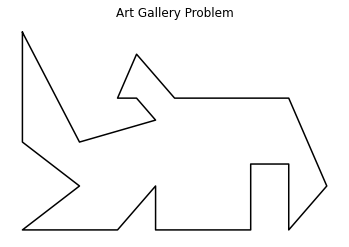

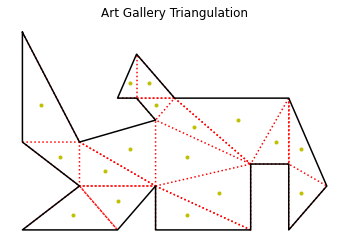

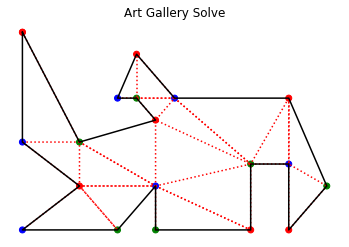

--- 0.62 seconds ---


In [5]:
start_time = time.time()

A1 = Coloring(df)
A1.PlotPolygon("Art Gallery Problem")
A1.PlotPolygon("Art Gallery Triangulation", cent=True, trian=True)
A1.PlotPolygon("Art Gallery Solve", trian=True, sol=True)

print("--- {:.2f} seconds ---".format(time.time() - start_time))

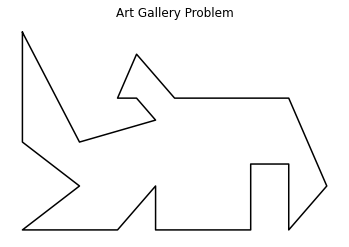

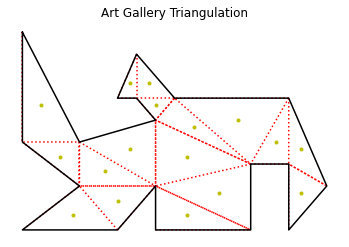

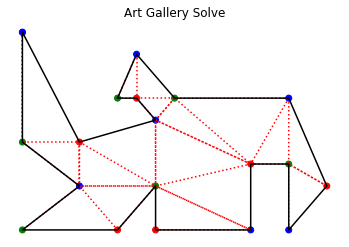

--- 0.62 seconds ---


In [6]:
start_time = time.time()

A2 = ColoringS(df)
A2.PlotPolygon("Art Gallery Problem")
A2.PlotPolygon("Art Gallery Triangulation", cent=True, trian=True)
A2.PlotPolygon("Art Gallery Solve", trian=True, sol=True)

print("--- {:.2f} seconds ---".format(time.time() - start_time))

## Conclusión

La realización de este trabajo mezcla los conceptos vistos en el parcial pasado, en especial sobre el manejo de segmentos de recta, no fue una tarea tediosa como lo fue el famoso 'Barrido de Linea Ordenado por la Abscisa', ya que manejando las estructuras de datos correcta se puede resolver de forma sencilla la problemática sin tener que recurrir a algoritmos brutos sacados de la manga, de igual forma vemos la importancia de la figura geométrica conocida como triángulo, es una figura de vital importancia en la Geometría ya que se pueden crear triángulos a partir de Polígonos siendo una pieza clave en la solución del problema el Algoritmo de Triangulación de Delaunay. Se pudo lograr la implementación de la coloración de vertices gracias a los algoritmos adecuados entre ellos el DFS para la composición de una solución que pueda resolver dicho problema en la mayor cantidad de Polígonos posibles.